In [1]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    f1_score,
)
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
print(df.head())

# Dataset overview
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  
Number of rows: 5572
Number of columns: 5


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
for i in df.columns:
    print(f"No. of unique values in '{i}' is {len(df[i].unique())}")

# Rename columns for better clarity
df.rename(columns={"v1": "Category", "v2": "Message"}, inplace=True)

# Remove unnamed columns
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

No. of unique values in 'v1' is 2
No. of unique values in 'v2' is 5169
No. of unique values in 'Unnamed: 2' is 44
No. of unique values in 'Unnamed: 3' is 11
No. of unique values in 'Unnamed: 4' is 6


In [5]:
df['Spam'] = df['Category'].apply(lambda x: 1 if x == 'spam' else 0)


In [6]:
df.head()

,Category,Message,Spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [7]:
duplicates = df[df.duplicated(keep=False)]


In [8]:
# Check for duplicates based only on 'Category' and 'Message' columns
duplicates_specific = df[df.duplicated(subset=['Category', 'Message'], keep=False)]

# Display the duplicates based on these specific columns
print(f"Number of duplicates based on 'Category' and 'Message': {len(duplicates_specific)}")
print(duplicates_specific)


Number of duplicates based on 'Category' and 'Message': 684
     Category                                            Message  Spam
2        spam  Free entry in 2 a wkly comp to win FA Cup fina...     1
7         ham  As per your request 'Melle Melle (Oru Minnamin...     0
8        spam  WINNER!! As a valued network customer you have...     1
9        spam  Had your mobile 11 months or more? U R entitle...     1
11       spam  SIX chances to win CASH! From 100 to 20,000 po...     1
...       ...                                                ...   ...
5524     spam  You are awarded a SiPix Digital Camera! call 0...     1
5535      ham  I know you are thinkin malaria. But relax, chi...     0
5539      ham                         Just sleeping..and surfing     0
5553      ham                        Hahaha..use your brain dear     0
5558      ham                             Sorry, I'll call later     0

[684 rows x 3 columns]


In [9]:
# Compare flagged duplicate rows
duplicate_groups = df[df.duplicated(keep=False)].groupby(['Category', 'Message'])

# Print the groups that show differences in other columns
for key, group in duplicate_groups:
    if len(group) > 1:  # Only show groups with multiple entries
        print("\nGroup with key:", key)
        print(group)



Group with key: ('ham', '1) Go to write msg 2) Put on Dictionary mode 3)Cover the screen with hand, 4)Press  &lt;#&gt; . 5)Gently remove Ur hand.. Its interesting..:)')
     Category                                            Message  Spam
1372      ham  1) Go to write msg 2) Put on Dictionary mode 3...     0
2162      ham  1) Go to write msg 2) Put on Dictionary mode 3...     0
2343      ham  1) Go to write msg 2) Put on Dictionary mode 3...     0

Group with key: ('ham', '7 wonders in My WORLD 7th You 6th Ur style 5th Ur smile 4th Ur Personality 3rd Ur Nature 2nd Ur SMS and 1st \\Ur Lovely Friendship\\"... good morning dear"')
     Category                                            Message  Spam
1469      ham  7 wonders in My WORLD 7th You 6th Ur style 5th...     0
1778      ham  7 wonders in My WORLD 7th You 6th Ur style 5th...     0
2980      ham  7 wonders in My WORLD 7th You 6th Ur style 5th...     0
4554      ham  7 wonders in My WORLD 7th You 6th Ur style 5th...     0

Group 

In [10]:
df = df.drop_duplicates(subset=['Category', 'Message'], keep='first')


In [11]:
dup = df.duplicated().sum()
print(f'Number of duplicated rows: {dup}')

Number of duplicated rows: 0


In [12]:
duplicates.to_csv('duplicate_rows.csv', index=False)


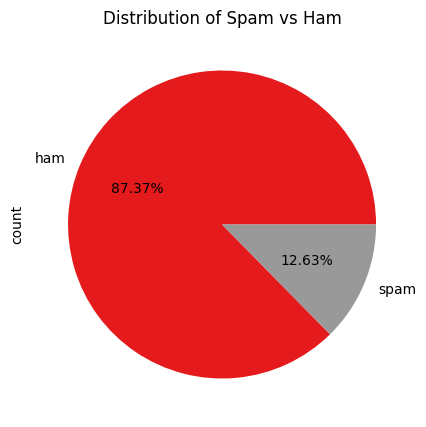

In [13]:
spread = df['Category'].value_counts()
plt.figure(figsize=(5, 5))
spread.plot(kind='pie', autopct='%1.2f%%', cmap='Set1')
plt.title('Distribution of Spam vs Ham')
plt.show()

In [14]:
df_spam = df[df['Category'] == 'spam'].copy()

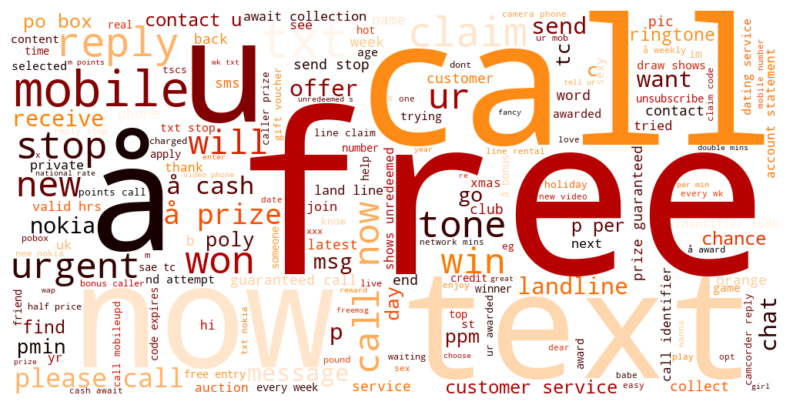

In [15]:
comment_words = ''
stopwords = set(STOPWORDS)

# Build a single string for all spam messages with text preprocessing
for val in df_spam.Message:
    val = str(val).lower()  # Convert to lowercase
    val = re.sub(r'[^\w\s]', '', val)  # Remove punctuations
    val = re.sub(r'\d+', '', val)  # Remove numeric characters
    val = val.split()  # Split into words
    comment_words += ' '.join(val) + ' '  # Rejoin words into a single string

# Create WordCloud
wordcloud = WordCloud(
    width=1000, height=500, background_color='white',
    stopwords=stopwords, min_font_size=10, max_words=1000,
    colormap='gist_heat_r'
).generate(comment_words)

# Display the WordCloud
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    df.Message, df.Spam, test_size=0.3, random_state=42, stratify=df.Spam
)

# Vectorize text using CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Step 2: Apply SMOTE for handling class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vectorized, y_train)

In [17]:
def evaluate_model_with_recommendations(model, X_train, X_test, y_train, y_test):
    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Probability predictions for ROC-AUC
    pred_prob_train = model.predict_proba(X_train)[:, 1] if hasattr(model, 'predict_proba') else None
    pred_prob_test = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Evaluate metrics
    roc_auc_train = roc_auc_score(y_train, pred_prob_train) if pred_prob_train is not None else "N/A"
    roc_auc_test = roc_auc_score(y_test, pred_prob_test) if pred_prob_test is not None else "N/A"

    print("\nTrain ROC AUC:", roc_auc_train)
    print("Test ROC AUC:", roc_auc_test)
    print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
    print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
    print("Train F1:", f1_score(y_train, y_pred_train))
    print("Test F1:", f1_score(y_test, y_pred_test))

    # Plot ROC Curve
    if pred_prob_train is not None and pred_prob_test is not None:
        fpr_train, tpr_train, _ = roc_curve(y_train, pred_prob_train)
        fpr_test, tpr_test, _ = roc_curve(y_test, pred_prob_test)
        plt.figure()
        plt.plot(fpr_train, tpr_train, label=f"Train ROC AUC: {roc_auc_train:.2f}")
        plt.plot(fpr_test, tpr_test, label=f"Test ROC AUC: {roc_auc_test:.2f}")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.show()

    # Confusion matrix
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=ax[0])
    ax[0].set_title("Train Confusion Matrix")
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("Actual")
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax[1])
    ax[1].set_title("Test Confusion Matrix")
    ax[1].set_xlabel("Predicted")
    ax[1].set_ylabel("Actual")
    plt.show()

    # Classification report
    print("\nTrain Classification Report:")
    print(classification_report(y_train, y_pred_train))
    print("\nTest Classification Report:")
    print(classification_report(y_test, y_pred_test))

    results = {
        "Train Accuracy": accuracy_score(y_train, y_pred_train),
        "Test Accuracy": accuracy_score(y_test, y_pred_test),
        "Train ROC AUC": roc_auc_train,
        "Test ROC AUC": roc_auc_test,
        "Train F1": f1_score(y_train, y_pred_train),
        "Test F1": f1_score(y_test, y_pred_test)
    }
    return results


Tuning hyperparameters for Naive Bayes...
Best parameters for Naive Bayes: {'nb__alpha': 0.05}
Best cross-validated accuracy for Naive Bayes: 0.9219

Train ROC AUC: 0.9983095397476216
Test ROC AUC: 0.9869493184727766
Train Accuracy: 0.9955776672194583
Test Accuracy: 0.9864603481624759
Train F1: 0.9825708061002179
Test F1: 0.9448818897637795


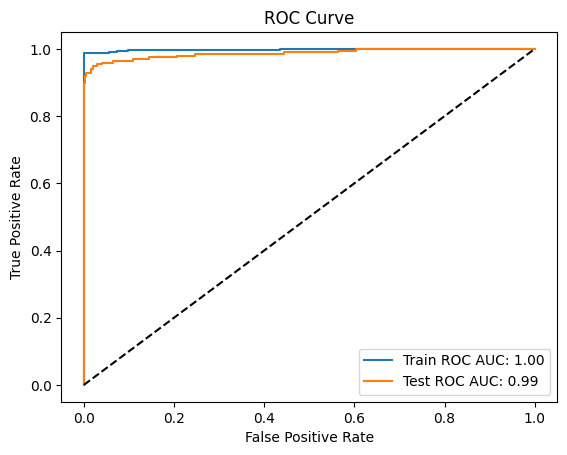

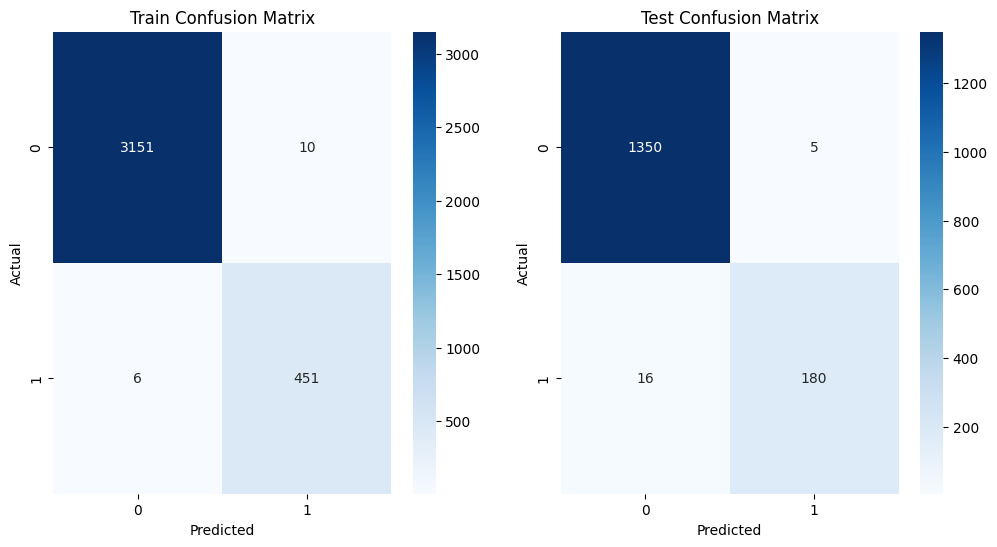


Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3161
           1       0.98      0.99      0.98       457

    accuracy                           1.00      3618
   macro avg       0.99      0.99      0.99      3618
weighted avg       1.00      1.00      1.00      3618


Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1355
           1       0.97      0.92      0.94       196

    accuracy                           0.99      1551
   macro avg       0.98      0.96      0.97      1551
weighted avg       0.99      0.99      0.99      1551


Tuning hyperparameters for Logistic Regression...
Best parameters for Logistic Regression: {'lr__C': 10, 'lr__solver': 'lbfgs'}
Best cross-validated accuracy for Logistic Regression: 0.9579

Train ROC AUC: 1.0
Test ROC AUC: 0.9809887792755478
Train Accuracy: 0.9997236042012161
Test Acc

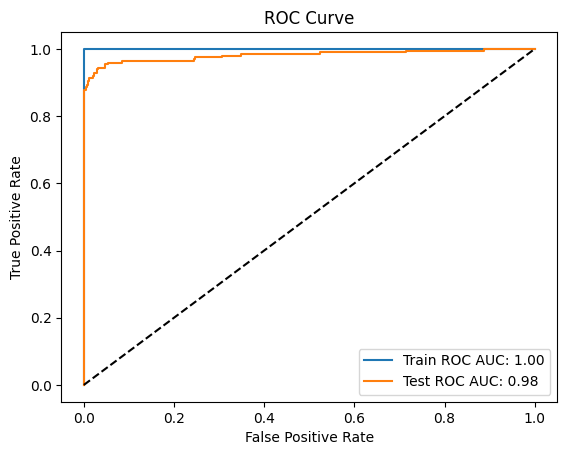

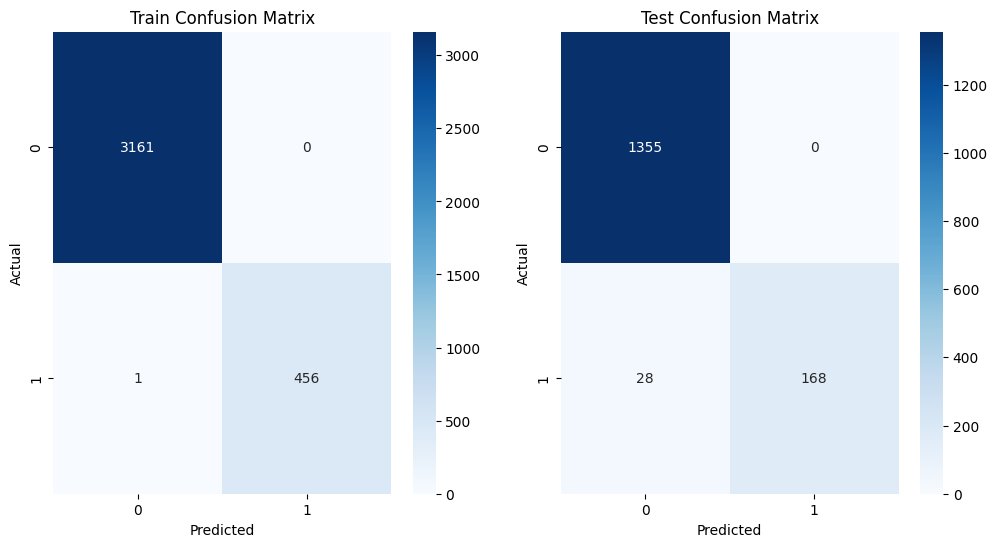


Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3161
           1       1.00      1.00      1.00       457

    accuracy                           1.00      3618
   macro avg       1.00      1.00      1.00      3618
weighted avg       1.00      1.00      1.00      3618


Test Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1355
           1       1.00      0.86      0.92       196

    accuracy                           0.98      1551
   macro avg       0.99      0.93      0.96      1551
weighted avg       0.98      0.98      0.98      1551


Tuning hyperparameters for SVM...
Best parameters for SVM: {'svm__C': 10, 'svm__kernel': 'rbf'}
Best cross-validated accuracy for SVM: 0.9535

Train ROC AUC: 1.0
Test ROC AUC: 0.985872430152873
Train Accuracy: 0.9997236042012161
Test Accuracy: 0.97678916827853
Train F1: 0.9989047097480

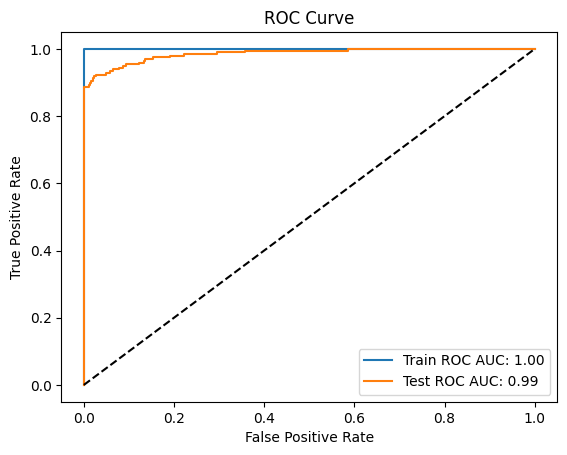

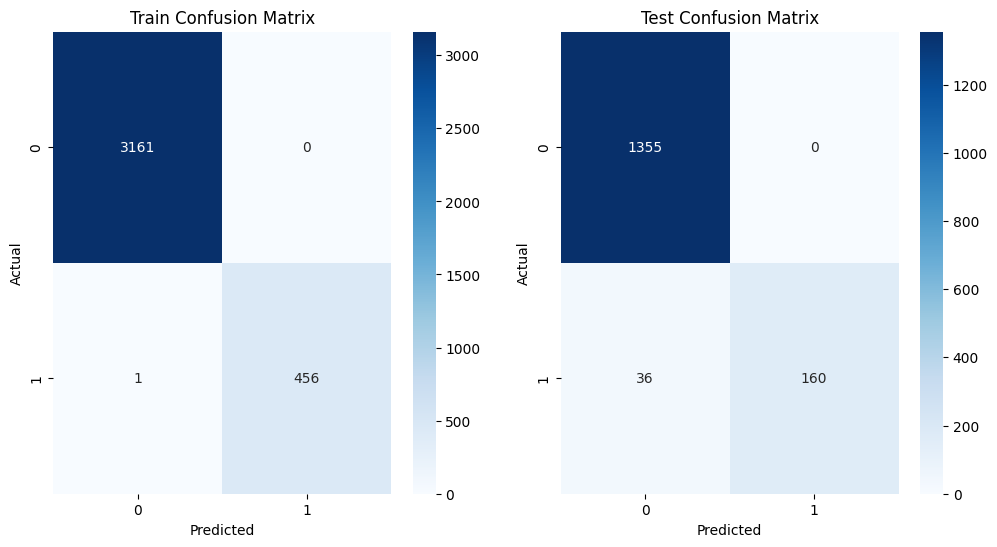


Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3161
           1       1.00      1.00      1.00       457

    accuracy                           1.00      3618
   macro avg       1.00      1.00      1.00      3618
weighted avg       1.00      1.00      1.00      3618


Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1355
           1       1.00      0.82      0.90       196

    accuracy                           0.98      1551
   macro avg       0.99      0.91      0.94      1551
weighted avg       0.98      0.98      0.98      1551


Tuning hyperparameters for Gradient Boosting...
Best parameters for Gradient Boosting: {'gb__learning_rate': 0.2, 'gb__n_estimators': 150}
Best cross-validated accuracy for Gradient Boosting: 0.9382

Train ROC AUC: 0.9999999999999999
Test ROC AUC: 0.9759865200692823
Train Accuracy: 1.0

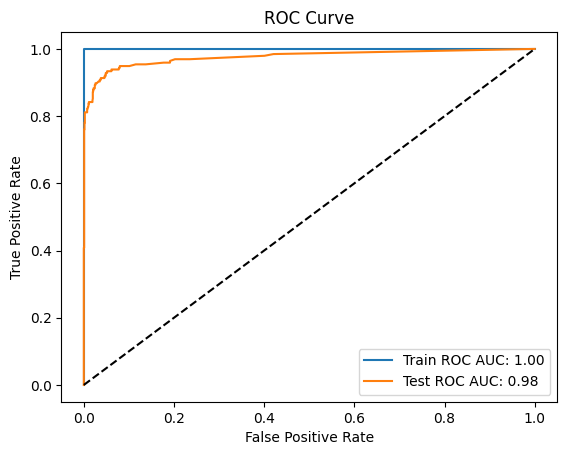

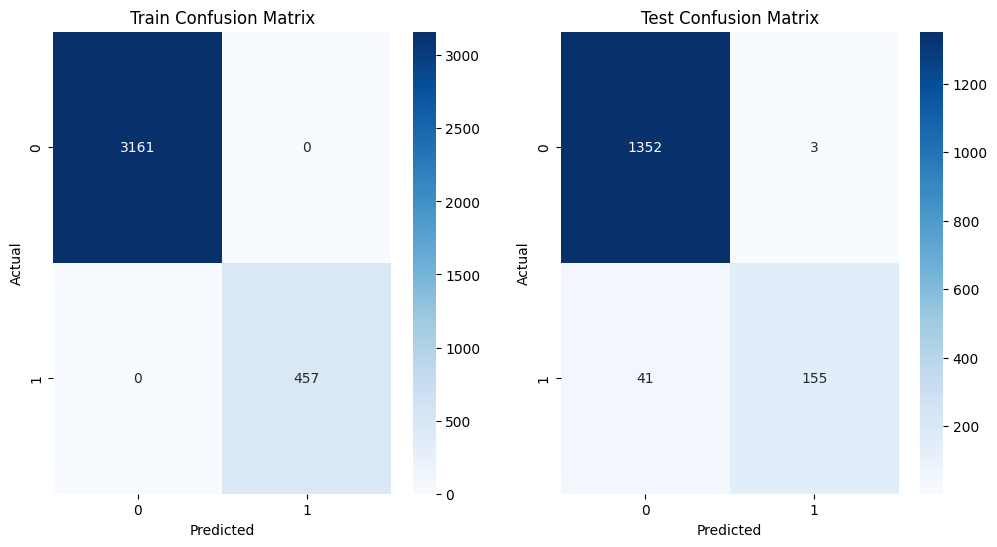


Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3161
           1       1.00      1.00      1.00       457

    accuracy                           1.00      3618
   macro avg       1.00      1.00      1.00      3618
weighted avg       1.00      1.00      1.00      3618


Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1355
           1       0.98      0.79      0.88       196

    accuracy                           0.97      1551
   macro avg       0.98      0.89      0.93      1551
weighted avg       0.97      0.97      0.97      1551


Model Comparison:
   Train Accuracy  Test Accuracy  Train ROC AUC  Test ROC AUC  Train F1  \
0        0.995578       0.986460        0.99831      0.986949  0.982571   
1        0.999724       0.981947        1.00000      0.980989  0.998905   
2        0.999724       0.976789        1.0

In [18]:
pipelines = {
    'Naive Bayes': Pipeline([('nb', MultinomialNB())]),
    'Logistic Regression': Pipeline([('lr', LogisticRegression(max_iter=1000))]),
    'SVM': Pipeline([('svm', SVC(probability=True))]),
    'Gradient Boosting': Pipeline([('gb', GradientBoostingClassifier())])
}

param_grids = {
    'Naive Bayes': {'nb__alpha': [0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 2.5, 3.0]},
    'Logistic Regression': {'lr__C': [0.1, 1, 10], 'lr__solver': ['liblinear', 'lbfgs']},
    'SVM': {'svm__C': [0.1, 1, 10], 'svm__kernel': ['linear', 'rbf']},
    'Gradient Boosting': {'gb__learning_rate': [0.01, 0.1, 0.2], 'gb__n_estimators': [50, 100, 150]}
}

# Step 6: GridSearchCV for each model
best_models = {}
model_comparison = []

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, pipeline in pipelines.items():
    print(f"\nTuning hyperparameters for {model_name}...")
    grid_search = GridSearchCV(
        pipeline, param_grids[model_name], scoring='accuracy', cv=stratified_kfold, n_jobs=-1
    )
    grid_search.fit(X_train_resampled, y_train_resampled)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_models[model_name] = best_model

    print(f"Best parameters for {model_name}: {best_params}")
    print(f"Best cross-validated accuracy for {model_name}: {best_score:.4f}")

    # Evaluate the best model on the test set
    evaluation_results = evaluate_model_with_recommendations(
        best_model, X_train_vectorized, X_test_vectorized, y_train, y_test
    )
    evaluation_results['Best Parameters'] = best_params
    model_comparison.append(evaluation_results)

# Step 7: Display final comparison
comparison_df = pd.DataFrame(model_comparison)
print("\nModel Comparison:")
print(comparison_df)